#**Setting up for Colab**

In [1]:
import os
import pandas as pd
from pathlib import Path
from google.colab import drive


drive.mount('/content/drive/')

# Define projectmap
eb_main = '/content/drive/MyDrive/EB_project/ebnerd-benchmark-main/src'
os.chdir(eb_main)


Mounted at /content/drive/


# **Import Functions**

In [2]:
import polars as pl

from ebrec.utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_IMPRESSION_ID_COL,
    DEFAULT_SUBTITLE_COL,
    DEFAULT_LABELS_COL,
    DEFAULT_TITLE_COL,
    DEFAULT_USER_COL,
    DEFAULT_IMPRESSION_TIMESTAMP_COL,
)

from ebrec.utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    add_known_user_column,
    add_prediction_scores,
    truncate_history,
)

from ebrec.evaluation import MetricEvaluator, AucScore, NdcgScore, MrrScore, F1Score
from ebrec.utils._articles import convert_text2encoding_with_transformers
from ebrec.utils._polars import concat_str_columns, slice_join_dataframes
from ebrec.utils._articles import create_article_id_to_value_mapping
from ebrec.utils._nlp import get_transformers_word_embeddings
from ebrec.models.newsrec.dataloader import NRMSDataLoader
import datetime


In [3]:
def ebnerd_from_path(path: Path, history_size: int = 30, padding: int = 0,) -> pl.DataFrame:
    """
    Load ebnerd - function
    """
    df_history = (
        pl.scan_parquet(path.joinpath("history.parquet"))
        .select(DEFAULT_USER_COL, DEFAULT_HISTORY_ARTICLE_ID_COL)
        .pipe(
            truncate_history,
            column=DEFAULT_HISTORY_ARTICLE_ID_COL,
            history_size=history_size,
            padding_value=0,
            enable_warning=False,
        )
    )
    df_behaviors = (
        pl.scan_parquet(path.joinpath("behaviors.parquet"))
        .collect()
        .pipe(
            slice_join_dataframes,
            df2=df_history.collect(),
            on=DEFAULT_USER_COL,
            how="left",
        )
    )
    return df_behaviors

In [4]:
PATH = Path("/content/drive/MyDrive/EB_project").expanduser()

# Datasplit-folder
DATASPLIT = "ebnerd_small"

DUMP_DIR = PATH.joinpath("dump_artifacts")
DUMP_DIR.mkdir(exist_ok=True, parents=True)

print(f"PATH: {PATH}")
print(f"DUMP_DIR: {DUMP_DIR}")


PATH: /content/drive/MyDrive/EB_project
DUMP_DIR: /content/drive/MyDrive/EB_project/dump_artifacts


In [5]:
COLUMNS = [
    DEFAULT_USER_COL,
    DEFAULT_IMPRESSION_ID_COL,
    DEFAULT_IMPRESSION_TIMESTAMP_COL,
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
]
HISTORY_SIZE = 20
FRACTION = 1


# **Load data**

In [6]:
# Load test

df_test = (
    ebnerd_from_path(
        PATH.joinpath(DATASPLIT, "validation"),
        history_size=HISTORY_SIZE,
        padding=0,
    )
    .select(COLUMNS)
    .pipe(create_binary_labels_column)
    .sample(fraction=FRACTION)
)
print("Test: ",len(df_test))


# Load articles
df_articles = pl.read_parquet(PATH.joinpath(DATASPLIT,"articles.parquet"))
print("Articles: ", len(df_articles))

Test:  244647
Articles:  20738


# **Preprocessing subtitles**

In [7]:
pre_proc = '/content/drive/MyDrive/EB_project/ebnerd-benchmark-main'
os.chdir(pre_proc)

from preproc_pred import clean_text_column


# Convert subtitle column to a list, clean it, and add it back
cleaned_subtitles = df_articles["subtitle"].to_list()
cleaned_subtitles = [clean_text_column(text) for text in cleaned_subtitles]

# Add the cleaned subtitles as a new column
df_articles = df_articles.with_columns(
    pl.Series("subtitle_cleaned", cleaned_subtitles)
)


# **Load Roberta**

In [8]:
# Load model
from transformers import AutoTokenizer, AutoModel

TRANSFORMER_MODEL_NAME = "FacebookAI/xlm-roberta-base"

# LOAD HUGGINGFACE:
transformer_model = AutoModel.from_pretrained(TRANSFORMER_MODEL_NAME)
transformer_tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)

TEXT_COLUMNS_TO_USE = ["title", "subtitle_cleaned"]
MAX_TITLE_LENGTH = 20

word2vec_embedding = get_transformers_word_embeddings(transformer_model)
#
df_articles, cat_cal = concat_str_columns(df_articles, columns=TEXT_COLUMNS_TO_USE)
df_articles, token_col_title = convert_text2encoding_with_transformers(
    df_articles, transformer_tokenizer, cat_cal, max_length=MAX_TITLE_LENGTH
)
# =>
article_mapping = create_article_id_to_value_mapping(
    df=df_articles, value_col=token_col_title
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

# **Initiate the dataloader**

In [9]:
test_dataloader = NRMSDataLoader(
    behaviors=df_test,
    article_dict=article_mapping,
    unknown_representation="zeros",
    history_column=DEFAULT_HISTORY_ARTICLE_ID_COL,
    eval_mode=True,
    batch_size=32,
)

# **Load NRMS-model**

In [10]:
from Our_NRMS_model import NRMSModel, HParams
import torch
import os

# Define paths for saving
BASE_DIR = "/content/drive/MyDrive/EB_project"
MODEL_NAME = "NRMSModel"
MODEL_WEIGHTS = os.path.join(BASE_DIR, f"state_dict/{MODEL_NAME}/weights.pth")

# Initialiser hyperparametre
hparams = HParams()

# Placeholder for embedding (sørg for korrekt initialisering)

# Initialiser modellen
model = NRMSModel(hparams=hparams, word2vec_embedding=word2vec_embedding, seed=123)

# Flyt modellen til GPU, hvis tilgængelig
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Indlæs vægtene fra filen
if os.path.exists(MODEL_WEIGHTS):
    try:
        # Indlæs vægtene med map_location og weights_only=True, hvis muligt
        state_dict = torch.load(MODEL_WEIGHTS, map_location=device)
        model.load_state_dict(state_dict, strict=False)  # Tillad fleksibilitet i vægtindlæsning
        print("Model weights loaded successfully.")
    except RuntimeError as e:
        print(f"Failed to load model weights: {e}")
else:
    raise FileNotFoundError(f"Weights file not found at {MODEL_WEIGHTS}")


<ipython-input-10-74e8aee59597>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MODEL_WEIGHTS, map_location=device)


Model weights loaded successfully.


# **Compute predictions** (Around 2 hours with A800 GPU in Colab)

In [11]:
import numpy as np

# --- Testing phase ---
model.eval()  # Set the model to evaluation mode
test_predictions = []

with torch.no_grad():  # Disable gradient calculation for inference
    for batch_idx, batch in enumerate(test_dataloader):
        (history_titles, candidate_titles), labels = batch

        # Move data to device
        history_titles = torch.tensor(history_titles, dtype=torch.long, device=device)
        candidate_titles = torch.tensor(candidate_titles, dtype=torch.long, device=device)

        # Forward pass to get scores
        scores = model(history_titles, candidate_titles)

        probabilities = torch.sigmoid(scores)

        # Collect predictions
        test_predictions.extend(probabilities.cpu().numpy())

# Convert predictions to numpy array
test_predictions = np.array(test_predictions)


# **Add predictions and compute metrics**

In [12]:
from preproc_pred import add_prediction_scores

# Add predictions to dataframe
df_test = add_prediction_scores(
    df=df_test,
    scores=test_predictions.tolist(),
    inview_col="article_ids_inview"
)

# Compute metrics
metrics = MetricEvaluator(
    labels=df_test["labels"].to_list(),
    predictions=df_test["scores"].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
        F1Score(threshold=0.5),
    ],
)
results = metrics.evaluate()
print(results)


<MetricEvaluator class>: 
 {
    "auc": 0.5644837382639218,
    "mrr": 0.3459273796777715,
    "ndcg@5": 0.3895380221724382,
    "ndcg@10": 0.46475923210541503,
    "f1": 0.06216195261731217
}


# **Confusion matrix**

True Positives (TP): 19674
False Positives (FP): 203548
True Negatives (TN): 2479772
False Negatives (FN): 225948


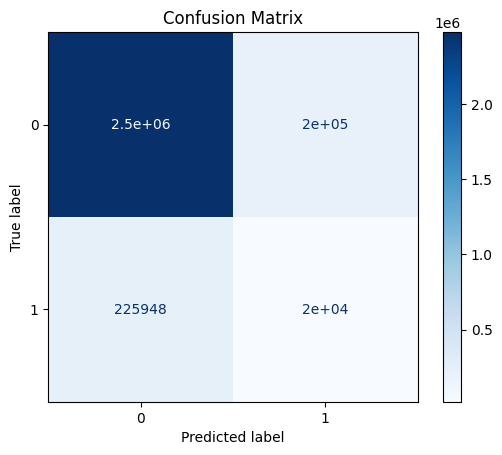

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Extract labels
labels = df_test["labels"].to_list()  # True labels
scores = df_test["scores"].to_list()  # Predicted probabilities

threshold = 0.5
predictions = [[1 if score > threshold else 0 for score in row] for row in scores]

# Flatten labels and predictions
flattened_labels = [label for sublist in labels for label in sublist]
flattened_predictions = [pred for sublist in predictions for pred in sublist]

# Compute the confusion matrix
cm = confusion_matrix(flattened_labels, flattened_predictions)
tn, fp, fn, tp = cm.ravel()

# Print metrics
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Visualize
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
